In [83]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from math import atan2

import energyflow as ef
from energyflow.archs import PFN, EFN
from energyflow.utils import to_categorical

from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense
from keras.models import Model, Sequential

import pylhe
plt.rcParams["font.family"] = "serif"

In [58]:
myweights_full=[]
X_full = []
mycounter = 0
for e in open('/data0/bpnachman/NeuralPosReweight/TruthttbarQCD_5.txt'):
    myweights_full+=[float(e.split()[0])]
    nparts = int(len(e.split()[1:])/6)
    myevent = []
    for i in range(nparts):
        pT = float(e.split()[1:][6*i+1])
        eta = float(e.split()[1:][6*i+2])
        phi = float(e.split()[1:][6*i+3])
        m = float(e.split()[1:][6*i+4])
        pid = int(e.split()[1:][6*i+5])
        myevent+=[[pT,eta,phi,m,pid]]
        #print(". ",i,pT,eta,phi,m,pid)
    myevent = np.array(myevent)
    X_full+=[myevent]
    #print(nparts)
    #print(e.split()[1:])
    #if (mycounter > 1):
    #    break
    mycounter+=1
    if (mycounter%100000==0):
        print(mycounter)

100000
200000
300000
400000
500000


In [108]:
X_full = np.array(X_full)

In [109]:
X_full[0][:,4]

array([13., 14., 13., 14.,  1.,  1.,  0.])

In [59]:
X_full_copy = X_full.copy()

In [60]:
X_full_copy_fixed = []
for i in range(len(X_full_copy)):
    myoutput=np.zeros([15,5])
    for j in range(min(len(X_full_copy[i]),15)):
        myoutput[j,:] = X_full_copy[i][j][:]
        myoutput[j,4] /= 20.
        myoutput[j,1:3] /= np.pi
        myoutput[j,0] /= 100.
        pass
    X_full_copy_fixed+=[myoutput]
np.shape(X_full_copy_fixed)

(500000, 15, 5)

In [61]:
Wf = myweights_full.copy()
Wf /= np.mean(np.abs(Wf))
Xf = X_full_copy_fixed.copy()
Xf = np.array(Xf)

In [62]:
xf_vals = np.concatenate([Xf,Xf])
yf_vals = np.concatenate([np.ones(len(Xf)),np.zeros(len(Xf))])
wf_vals = np.concatenate([Wf,np.ones(len(Wf))])
yf_vals = to_categorical(yf_vals, num_classes=2)

In [63]:
Xf_train, Xf_val, Yf_train, Yf_val, Wf_train, Wf_val = train_test_split(xf_vals, yf_vals, wf_vals, test_size=0.2)

In [64]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
pfnf = PFN(input_dim=Xf.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 5)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation_22 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_22[0][0]              
__________________________________________________________________________________________________
activation

In [87]:
num_epoch = 100
batch_size = 500 #was 5000
historyf = pfnf.fit(Xf_train, Yf_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(Xf_val, Yf_val, Wf_val),
          sample_weight=Wf_train,
          verbose=1)

Train on 800000 samples, validate on 200000 samples
Epoch 1/100
800000/800000 [==============================] - 13s 17us/step - loss: 0.4874 - acc: 0.4999 - val_loss: 0.4870 - val_acc: 0.5002
Epoch 2/100
800000/800000 [==============================] - 13s 17us/step - loss: 0.4874 - acc: 0.5000 - val_loss: 0.4869 - val_acc: 0.5002
Epoch 3/100
800000/800000 [==============================] - 13s 17us/step - loss: 0.4874 - acc: 0.4999 - val_loss: 0.4869 - val_acc: 0.5002
Epoch 4/100
800000/800000 [==============================] - 13s 17us/step - loss: 0.4874 - acc: 0.5000 - val_loss: 0.4871 - val_acc: 0.5001
Epoch 5/100
800000/800000 [==============================] - 13s 16us/step - loss: 0.4874 - acc: 0.4999 - val_loss: 0.4872 - val_acc: 0.5001
Epoch 6/100
800000/800000 [==============================] - 13s 17us/step - loss: 0.4873 - acc: 0.5000 - val_loss: 0.4872 - val_acc: 0.5002
Epoch 7/100
800000/800000 [==============================] - 13s 17us/step - loss: 0.4873 - acc: 0.500

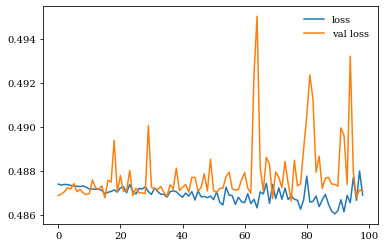

In [88]:
plt.plot(historyf.history['loss'][1:],label="loss")
plt.plot(historyf.history['val_loss'][1:],label="val loss")
plt.legend(frameon=False)

In [89]:
predsf = pfnf.predict(Xf_val, batch_size=1000)
learned_weightsf = predsf[:,1] / predsf[:,0]

In [90]:
nnonbjetsf = []
pTsISRf = []
for i in range(len(Xf_val)):
    nnonbjet = 0
    pTISR = 0.
    for j in range(len(Xf_val[i])):
        if (Xf_val[i][j][0] == 0):
            continue
        if (Xf_val[i][j][4]*20 < 10):
            if (Xf_val[i][j][4]*20 < 1):
                nnonbjet+=1
                if (Xf_val[i][j][0]*100 > pTISR):
                    pTISR = Xf_val[i][j][0]*100
                    pass
                pass
            pass
        pass
    nnonbjetsf+=[nnonbjet]
    pTsISRf+=[pTISR]
    pass
nnonbjetsf = np.array(nnonbjetsf)
pTsISRf = np.array(pTsISRf)

## Now for reducing the stats.

In [91]:
keepprobs = learned_weightsf[Yf_val[:,0]==0]**2
for i in range(len(keepprobs)):
    if (keepprobs[i] > 1.):
        keepprobs[i]=1.
        pass
    pass
keep = np.random.binomial(1,keepprobs)
initweights = learned_weightsf[Yf_val[:,0]==0]
initxvals1 = pTsISRf[Yf_val[:,0]==0]
initxvals2 = nnonbjetsf[Yf_val[:,0]==0]
neweights = []
newxvals1 = []
newxvals2 = []
for i in range(len(keep)):
    if (keep[i]==1):
        neweights+=[1./(0.00001+initweights[i])]
        newxvals1+=[initxvals1[i]]
        newxvals2+=[initxvals2[i]]
    pass

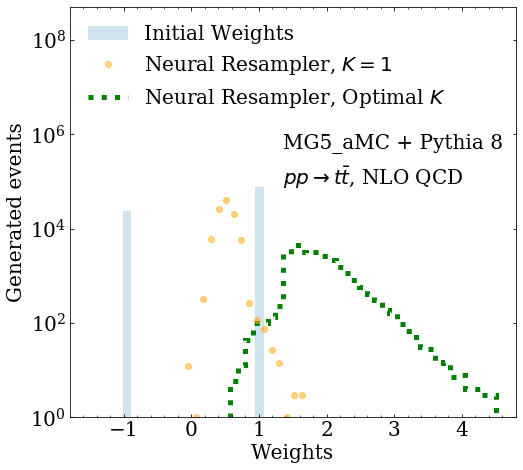

In [165]:
fig = plt.figure(figsize=(8, 7.55))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()
    
plt.hist(Wf_val[Yf_val[:,0]==0],alpha=0.2,bins=np.linspace(-1.5,4.5,50),density=False,label="Initial Weights")
#plt.hist(learned_weightsf[Yf_val[:,0]==0],alpha=0.5,bins=np.linspace(-1,4.5,50),density=False,label=r"Neural Resampler, $K=1$")
plt.hist(neweights,bins=np.linspace(-1,4.5,50),histtype="step",ls=":",linewidth=5,color="green")

myn,bmjj=np.histogram(learned_weightsf[Yf_val[:,0]==0],bins=np.linspace(-1,4.5,50))
myn2,_=np.histogram(neweights,bins=np.linspace(-1,4.5,50))
myn2+=[0]
plt.plot(0.5*(bmjj[1:]+bmjj[:-1]),myn,label=r"Neural Resampler, $K=1$",color='orange',alpha=0.5,marker='o',ls="")
plt.step(0.5*(bmjj[1:]+bmjj[:-1])+0.5*5.5/50,-1*myn2,label=r"Neural Resampler, Optimal $K$",color="green",ls=":",linewidth=5)

handles, labels = ax0.get_legend_handles_labels()
ax0.legend([handles[2],handles[0],handles[1]], [labels[2],labels[0],labels[1]],frameon=False,fontsize=20,loc="upper left")
#plt.legend(frameon=False,fontsize=20,loc="upper left")
plt.xlabel(r"Weights",fontsize=20)
plt.ylabel(r"Generated events",fontsize=20)
plt.locator_params(axis='y', nbins=6)
plt.yscale("log")

plt.ylim([1,5e8])
plt.text(1.35,5e5,"MG5_aMC + Pythia 8",fontsize=20)
plt.text(1.35,9e4,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)
plt.savefig("wisrpt_full.pdf",bbox_inches='tight')

In [93]:
neweights = np.array(neweights)

In [94]:
Bins_val = np.array([np.digitize(x,np.linspace(0,300,20)) for x in pTsISRf[Yf_val[:,0]==0]])
Bins_newval = np.array([np.digitize(x,np.linspace(0,300,20)) for x in newxvals1])

In [95]:
Bins2_val = np.array([np.digitize(x,range(10)) for x in nnonbjetsf[Yf_val[:,0]==0]])
Bins2_newval = np.array([np.digitize(x,range(10)) for x in newxvals2])

In [96]:
W2_original = [sum(Wf_val[Yf_val[:,0]==0][Bins_val==i]**2) for i in range(20)]
W2_new = [sum(learned_weightsf[Yf_val[:,0]==0][Bins_val==i]**2) for i in range(20)]
W2_sampled = [sum(neweights[Bins_newval==i]**2) for i in range(20)]

L2_original = [len(Wf_val[Yf_val[:,0]==0][Bins_val==i]**2) for i in range(20)]
L2_new = [len(learned_weightsf[Yf_val[:,0]==0][Bins_val==i]**2) for i in range(20)]
L2_sampled = [len(neweights[Bins_newval==i]**2) for i in range(20)]

In [97]:
W2_original2 = [sum(Wf_val[Yf_val[:,0]==0][Bins2_val==i]**2) for i in range(10)]
W2_new2 = [sum(learned_weightsf[Yf_val[:,0]==0][Bins2_val==i]**2) for i in range(10)]
W2_sampled2 = [sum(neweights[Bins2_newval==i]**2) for i in range(10)]

L2_original2 = [len(Wf_val[Yf_val[:,0]==0][Bins2_val==i]**2) for i in range(10)]
L2_new2 = [len(learned_weightsf[Yf_val[:,0]==0][Bins2_val==i]**2) for i in range(10)]
L2_sampled2 = [len(neweights[Bins2_newval==i]**2) for i in range(10)]

In [98]:
W2_original = np.array(W2_original)
W2_new = np.array(W2_new)
W2_sampled = np.array(W2_original)

L2_original = np.array(L2_original)
L2_new = np.array(L2_new)
L2_sampled = np.array(L2_sampled)

W2_original2 = np.array(W2_original2)
W2_new2 = np.array(W2_new2)
W2_sampled2 = np.array(W2_original2)

L2_original2 = np.array(L2_original2)
L2_new2 = np.array(L2_new2)
L2_sampled2 = np.array(L2_sampled2)

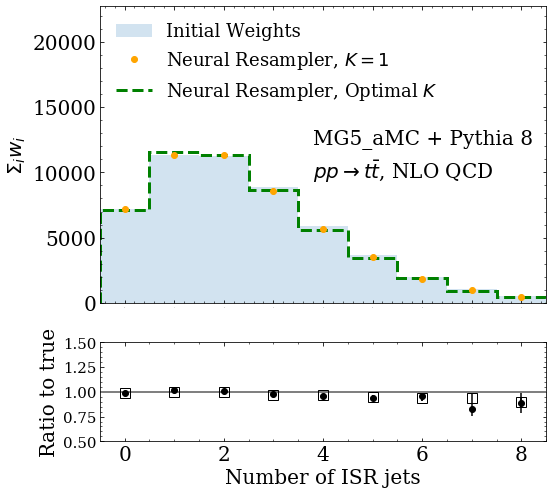

In [147]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.xlabel(r"",fontsize=20)
plt.ylabel(r"$\Sigma_i w_i$",fontsize=20)
plt.locator_params(axis='y', nbins=6)

#myn,bmjj,_=plt.hist(nnonbjetsf[Yf_val[:,0]==0],bins=range(10),alpha=0.5,density=False,label="Unweighted")
myn2,bmjj,_=plt.hist(nnonbjetsf[Yf_val[:,0]==0],bins=np.array(range(10))-0.5,weights=Wf_val[Yf_val[:,0]==0],alpha=0.2,density=False,label="Initial Weights")
myn3,_=np.histogram(nnonbjetsf[Yf_val[:,0]==0],bins=np.array(range(10))-0.5,weights=learned_weightsf[Yf_val[:,0]==0]) #,histtype="step",density=False,label="Neural Resampler, $K=1$",color="black")
myn4,_=np.histogram(newxvals2,bins=np.array(range(10))-0.5,weights=neweights) #,histtype="step",density=False,label=r"Neural Resampler, Optimal $K$",color="black",ls=":",linewidth=5)
_,_,_=plt.hist(newxvals2,bins=np.array(range(10))-0.5,weights=neweights,histtype="step",density=False,color="green",ls="--",linewidth=3)


plt.plot(0.5*(bmjj[1:]+bmjj[:-1]),myn3,label=r"Neural Resampler, $K=1$",ls="none",marker="o",color="orange")
plt.step(0.5*(bmjj[1:]+bmjj[:-1])+0.5,-myn4,label=r"Neural Resampler, Optimal $K$",ls="--",color="green",linewidth=3)

#plt.legend(frameon=False,fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend([handles[2],handles[0],handles[1]], [labels[2],labels[0],labels[1]],frameon=False,fontsize=18,loc="upper left")
plt.xticks(fontsize=0)
plt.xlim(-0.5,8.5)

plt.ylim([0,max(myn2)*2.])
plt.text(3.8,max(myn2)*1.07,"MG5_aMC + Pythia 8",fontsize=20)
plt.text(3.8,max(myn2)*0.85,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)

ax1 = plt.subplot(gs[1])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
ax1.minorticks_on()
plt.locator_params(axis='x', nbins=6)
plt.xlabel(r"Number of ISR jets",fontsize=20)
plt.ylabel("Ratio to true",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.axhline(y=1,linewidth=2, color='gray')   
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn3/myn2,yerr=(W2_new2[:-1]+myn2)**0.5/myn2,color='black',fmt='s',fillstyle="none",markersize=10)
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn4/myn2,yerr=(W2_sampled2[:-1]+myn2)**0.5/myn2,color='black',fmt="o")
#plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn/myn2,yerr=(myn+myn2)**0.5/myn2,color='#1f77b4',fmt='o',alpha=0.5)

plt.ylim(0.5,1.5)
plt.xlim(-0.5,8.5)

plt.savefig("ISRnjets_full_withk.pdf",bbox_inches='tight')

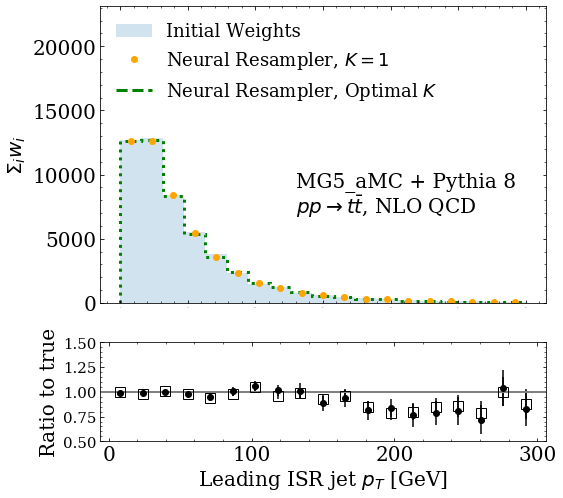

In [149]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.xlabel(r"",fontsize=20)
plt.ylabel(r"$\Sigma_i w_i$",fontsize=20)
plt.locator_params(axis='y', nbins=6)

#myn,bmjj,_=plt.hist(pTsISRf[Yf_val[:,0]==0],bins=np.linspace(0,300,20),alpha=0.5,density=False,label="Unweighted")
myn2,bmjj,_=plt.hist(pTsISRf[Yf_val[:,0]==0],bins=np.linspace(0,300,20),weights=Wf_val[Yf_val[:,0]==0],alpha=0.2,density=False,label="Initial Weights")
myn3,_=np.histogram(pTsISRf[Yf_val[:,0]==0],bins=np.linspace(0,300,20),weights=learned_weightsf[Yf_val[:,0]==0]) #,histtype="step",density=False,label=r"Neural Resampler, $K=1$",color="black")
myn4,_=np.histogram(newxvals1,bins=np.linspace(0,300,20),weights=neweights) #,histtype="step",density=False,label=r"Neural Resampler, Optimal $K$",color="black",ls=":",linewidth=5)
_,_,_=plt.hist(newxvals1,bins=np.linspace(0,300,20),weights=neweights,histtype="step",density=False,color="green",ls=":",linewidth=3)


plt.plot(0.5*(bmjj[1:]+bmjj[:-1]),myn3,label=r"Neural Resampler, $K=1$",ls="none",marker="o",color="orange")
plt.step(0.5*(bmjj[1:]+bmjj[:-1])+0.5,-myn4,label=r"Neural Resampler, Optimal $K$",ls="--",color="green",linewidth=3)

#plt.legend(frameon=False,fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend([handles[2],handles[0],handles[1]], [labels[2],labels[0],labels[1]],frameon=False,fontsize=18,loc="upper left")
plt.xticks(fontsize=0)

plt.ylim([0,max(myn2)*1.8])
plt.text(130,max(myn2)*0.7,"MG5_aMC + Pythia 8",fontsize=20)
plt.text(130,max(myn2)*0.55,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)

ax1 = plt.subplot(gs[1])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
ax1.minorticks_on()
plt.locator_params(axis='x', nbins=6)
plt.xlabel(r"Leading ISR jet $p_T$ [GeV]",fontsize=20)
plt.ylabel("Ratio to true",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.axhline(y=1,linewidth=2, color='gray')   
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn3/myn2,yerr=(W2_new[:-1]+myn2)**0.5/myn2,color='black',fmt='s',fillstyle="none",markersize=10)
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn4/myn2,yerr=(W2_sampled[:-1]+myn2)**0.5/myn2,color='black',fmt="o")
#plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn/myn2,yerr=(myn+myn2)**0.5/myn2,color='#1f77b4',fmt='o',alpha=0.5)
plt.ylim(0.5,1.5)
#plt.xlim(-0.5,9.5)

plt.savefig("ISRpT_full_withk.pdf",bbox_inches='tight')

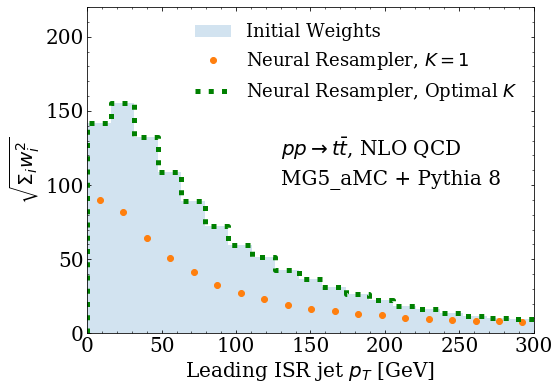

In [168]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.step(np.linspace(0,300,20),np.sqrt(W2_original),label="Initial Weights")
plt.hist([0,1],[-1,-1],label="Initial Weights",alpha=0.2)
plt.fill_between(np.linspace(0,300,20),np.array(W2_original)**0.5, step="pre", alpha=0.2)

plt.step(np.array(np.linspace(0,300,20))-0.5*300/20,np.sqrt(W2_new),label=r"Neural Resampler, $K=1$",marker='o',ls='none')
plt.step(np.linspace(0,300,20),np.sqrt(W2_sampled),label=r"Neural Resampler, Optimal $K$",ls=":",linewidth=5,color="green")
#plt.legend(frameon=False,fontsize=20,loc="upper right")
handles, labels = ax0.get_legend_handles_labels()
ax0.legend([handles[2],handles[0],handles[1]], [labels[2],labels[0],labels[1]],frameon=False,fontsize=18,loc="upper right")

plt.xlim([0,300])
plt.ylim([0,220])
plt.ylabel("$\sqrt{\Sigma_i w_i^2}$",fontsize=20)
plt.xlabel(r"Leading ISR jet $p_T$ [GeV]",fontsize=20)
plt.locator_params(axis='y', nbins=6)

plt.text(130,100,"MG5_aMC + Pythia 8",fontsize=20)
plt.text(130,120,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)

plt.savefig("ISRpT_full_withk_sumw2.pdf",bbox_inches='tight')

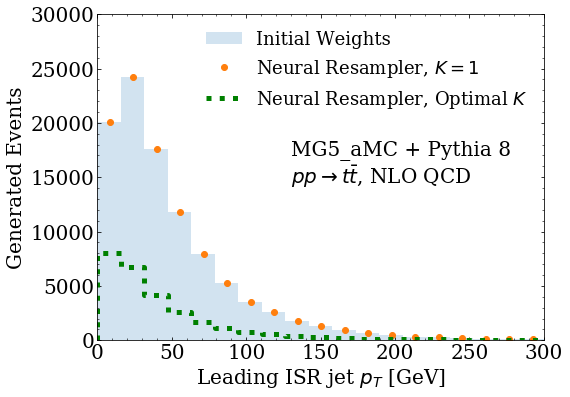

In [169]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.step(np.linspace(0,300,20),np.sqrt(W2_original),label="Initial Weights")
plt.hist([0,1],[-1,-1],label="Initial Weights",alpha=0.2)
plt.fill_between(np.linspace(0,300,20),L2_original, step="pre", alpha=0.2)

plt.step(np.array(np.linspace(0,300,20))-0.5*300/20,L2_new,label=r"Neural Resampler, $K=1$",marker='o',ls='none')
plt.step(np.linspace(0,300,20),L2_sampled,label=r"Neural Resampler, Optimal $K$",ls=":",linewidth=5,color="green")
#plt.legend(frameon=False,fontsize=20,loc="upper right")
handles, labels = ax0.get_legend_handles_labels()
ax0.legend([handles[2],handles[0],handles[1]], [labels[2],labels[0],labels[1]],frameon=False,fontsize=18,loc="upper right")

plt.text(130,17000,"MG5_aMC + Pythia 8",fontsize=20)
plt.text(130,14500,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)

plt.xlim([0,300])
plt.ylim([0,30000])
plt.ylabel("Generated Events",fontsize=20)
plt.xlabel(r"Leading ISR jet $p_T$ [GeV]",fontsize=20)
plt.locator_params(axis='y', nbins=6)
plt.savefig("ISRpT_full_withk_Number.pdf",bbox_inches='tight')

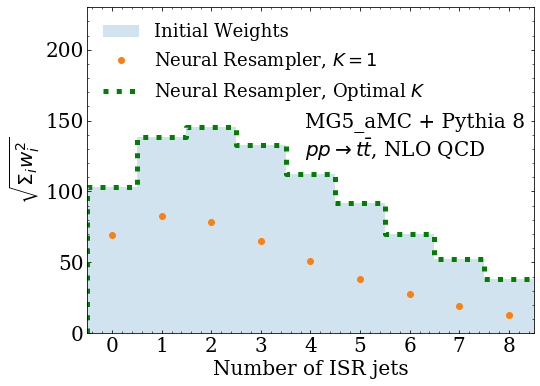

In [166]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.step(np.array(range(10))-0.5,np.sqrt(W2_original2),label="Initial Weights")
plt.hist([0,1],[-1,-1],label="Initial Weights",alpha=0.2)
plt.fill_between(np.array(range(10))-0.5,np.sqrt(W2_original2), step="pre", alpha=0.2)

plt.step(np.array(range(10))-1,np.sqrt(W2_new2),label=r"Neural Resampler, $K=1$",marker='o',ls='none')
plt.step(np.array(range(10))-0.5,np.sqrt(W2_sampled2),label=r"Neural Resampler, Optimal $K$",ls=":",linewidth=5,color="green")
#plt.legend(frameon=False,fontsize=20,loc="upper right")
handles, labels = ax0.get_legend_handles_labels()
ax0.legend([handles[2],handles[0],handles[1]], [labels[2],labels[0],labels[1]],frameon=False,fontsize=18,loc="upper left")

plt.xlim([-0.5,8.5])
plt.ylim([0,230])
plt.ylabel(r"$\sqrt{\Sigma_i w_i^2}$",fontsize=20)
plt.xlabel(r"Number of ISR jets",fontsize=20)
plt.locator_params(axis='y', nbins=6)

plt.text(3.9,145,"MG5_aMC + Pythia 8",fontsize=20)
plt.text(3.9,125,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)

plt.savefig("ISRnjets_full_withk_sumw2.pdf",bbox_inches='tight')

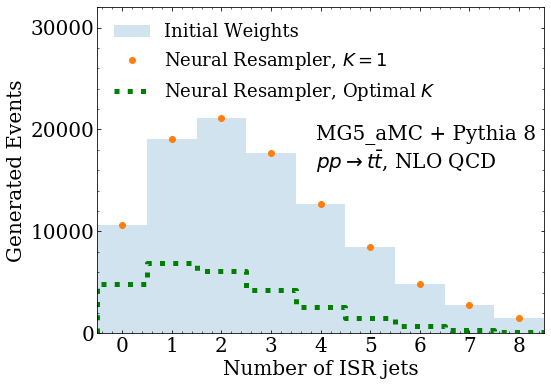

In [167]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.step(np.array(range(10))-0.5,L2_original2,label="Initial Weights")
plt.hist([0,1],[-1,-1],label="Initial Weights",alpha=0.2)
plt.fill_between(np.array(range(10))-0.5,L2_original2, step="pre", alpha=0.2)

plt.step(np.array(range(10))-1,L2_new2,label=r"Neural Resampler, $K=1$",marker='o',ls='none')
plt.step(np.array(range(10))-0.5,L2_sampled2,label=r"Neural Resampler, Optimal $K$",ls=":",linewidth=5,color="green")
#plt.legend(frameon=False,fontsize=20,loc="upper right")
handles, labels = ax0.get_legend_handles_labels()
ax0.legend([handles[2],handles[0],handles[1]], [labels[2],labels[0],labels[1]],frameon=False,fontsize=18,loc="upper left")

plt.xlim([-0.5,8.5])
plt.ylim([0,32000])
plt.ylabel("Generated Events",fontsize=20)
plt.xlabel(r"Number of ISR jets",fontsize=20)
plt.locator_params(axis='y', nbins=6)

plt.text(3.9,19000,"MG5_aMC + Pythia 8",fontsize=20)
plt.text(3.9,16200,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)

plt.savefig("ISRnjets_full_withk_Number.pdf",bbox_inches='tight')